In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path

In [4]:
import plotly.express as px  # plotly still uncooperative
import matplotlib.pyplot as plt

# sys.path.insert(0, os.path.join(Path(__file__).parents[1]))
notebook_dir = Path(os.getcwd())
src_dir = notebook_dir.parent / 'src'
sys.path.insert(0, str(src_dir))
from to_postgres import PgHook
import mc_core

# make database helper object
db = PgHook()

### Monte Carlo Class
Parameters passed: 
1) port_list
2) mc_table  <== no, going to keep it external

In [5]:
# get full portfolio
sql = "select db_name from portfolio where sector_id <> 7"
df = db.alc_query(sql)
port_list = df["db_name"].tolist()
port_list

['civi',
 'cpg',
 'crk',
 'mgy',
 'mro',
 'pr',
 'rrc',
 'sm',
 'vet',
 'gpor',
 'chrd',
 'ovv',
 'pbf',
 'vlo',
 'dino',
 'parr',
 'psx',
 'cvi',
 'mpc',
 'ts',
 'lbrt',
 'bp',
 'e',
 'shel',
 'tte',
 'arlp',
 'btu',
 'ceix',
 'arch']

In [6]:
# button to compute the simulations & store to db tables

# calculate the number of stocks in portfolio
N = len(port_list)

In [7]:
columns = ", ".join(port_list)
sql2 = f"select price_date, {columns} from prices"
print(f"port select: {sql2}")
port = db.alc_query(sql2)

port select: select price_date, civi, cpg, crk, mgy, mro, pr, rrc, sm, vet, gpor, chrd, ovv, pbf, vlo, dino, parr, psx, cvi, mpc, ts, lbrt, bp, e, shel, tte, arlp, btu, ceix, arch from prices


In [8]:
port.set_index('price_date', inplace=True)
port

,civi,cpg,crk,mgy,mro,pr,rrc,sm,vet,gpor,...,ts,lbrt,bp,e,shel,tte,arlp,btu,ceix,arch
price_date,,,,,,,,,,,,,,,,,,,,,
2004-12-13,NaN,None,91.444206,NaN,6.828489,NaN,12.342578,18.161203,NaN,NaN,...,5.999661,NaN,21.446377,14.242051,20.704617,17.925936,3.521539,NaN,NaN,NaN
2004-12-14,NaN,None,93.237244,NaN,6.846983,NaN,12.397740,18.355621,NaN,NaN,...,6.017971,NaN,21.413746,14.313915,20.675468,17.869490,3.653377,NaN,NaN,NaN
2004-12-15,NaN,None,96.599159,NaN,6.945009,NaN,12.851241,18.482208,NaN,NaN,...,6.221826,NaN,21.540663,14.325700,20.737427,17.969097,3.701031,NaN,NaN,NaN
2004-12-16,NaN,None,94.940605,NaN,6.896916,NaN,12.930913,18.174774,NaN,NaN,...,6.005765,NaN,21.105505,14.194924,20.380253,17.595594,3.695735,NaN,NaN,NaN
2004-12-17,NaN,None,98.392189,NaN,6.902468,NaN,13.182174,18.545504,NaN,NaN,...,5.943511,NaN,21.163525,14.125420,20.274569,17.454508,3.703149,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-06,46.959999,None,14.520000,25.670000,NaN,14.67,33.750000,40.180000,9.55,175.740005,...,37.770000,17.23,28.700001,28.110001,63.250000,56.910000,26.469999,22.379999,117.110001,155.289993
2024-12-09,47.349998,None,14.740000,25.770000,NaN,14.80,34.130001,40.689999,9.76,174.179993,...,38.790001,17.42,30.090000,28.240000,64.699997,57.610001,25.889999,22.440001,115.949997,153.899994
2024-12-10,47.070000,None,15.220000,25.600000,NaN,14.77,33.980000,40.389999,9.53,173.380005,...,38.490002,18.48,30.100000,28.040001,64.379997,56.759998,25.670000,22.370001,115.879997,153.990005


In [9]:
# make a function to generate random portfolio weights
def gen_weights(N):
    weights = np.random.random(N)
    return weights / np.sum(weights)

# make a function to calculate an annualized portfolio return given a certain 
# portfolio weighting
def calculate_returns(weights, log_rets):
    # annualize return
    return np.sum(log_rets.mean() * weights) * 252

# create a function to calculate volatility
def calculate_volatility(weights, log_rets_cov):
    # annualized_cov = np.dot(log_rets.cov() * 252, weights)  # I think this is wrong and put in the one below
    annualized_cov = np.dot(log_rets_cov * 252, weights)
    vol = np.dot(weights.transpose(), annualized_cov)
    return np.sqrt(vol)

In [10]:
# recalculating the variables just to make this readable
log_rets = np.log(port / port.shift(1))
log_rets_cov = log_rets.cov()

TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method

In [17]:
'''
        Monte Carlo Simulation of Input Tickers
'''
# list to hold the returns from the monte carlo simulation
mc_portfolio_returns = []
mc_portfolio_vol = []
mc_weights = []

# note that the number of stocks in the portfolio makes the length of
# the simulation grow exponentially in complexity
for sim in range(6000):
    
    weights = gen_weights(N)
    mc_weights.append(weights)
    sim_returns = calculate_returns(weights, log_rets)
    mc_portfolio_returns.append(sim_returns)
    sim_volatility = calculate_volatility(weights, log_rets_cov)
    mc_portfolio_vol.append(sim_volatility)

In [18]:
# assume zero risk-free rate to calculate Sharpe ratio
mc_sharpe_ratios = np.array(mc_portfolio_returns / np.array(mc_portfolio_vol))

Graphing is not part of this chain

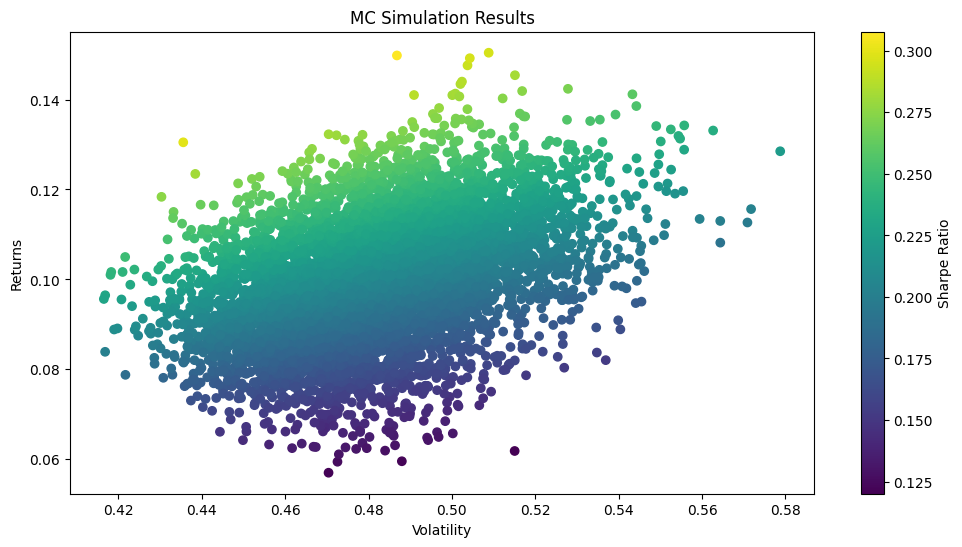

In [19]:
# plot simulation results
fig = plt.figure(figsize=(12,6))
plt.scatter(mc_portfolio_vol, mc_portfolio_returns, c=mc_sharpe_ratios)
plt.colorbar(label='Sharpe Ratio')
# plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
# plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('MC Simulation Results')
plt.show()

In [26]:
sql = "select return, volatility, sharpe from mc_all"
print(f"all sector sql: {sql}")
df = db.alc_query(sql)
df

all sector sql: select return, volatility, sharpe from mc_all


,return,volatility,sharpe
0,0.134054,0.460486,0.291114
1,0.137564,0.477266,0.288232
2,0.127699,0.443654,0.287834
3,0.143770,0.500155,0.287450
4,0.121971,0.425795,0.286455
...,...,...,...
5995,0.060687,0.489754,0.123913
5996,0.060188,0.488078,0.123316
5997,0.058064,0.491666,0.118097
5998,0.059212,0.504426,0.117386


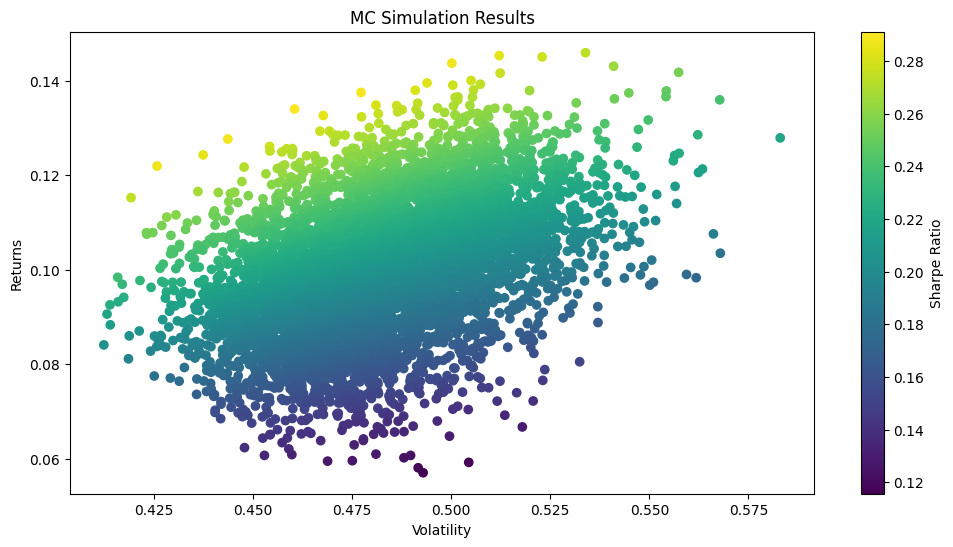

In [29]:
# plot simulation results
fig = plt.figure(figsize=(12, 6))
plt.scatter(df["volatility"], df["return"], c=df["sharpe"])
plt.colorbar(label="Sharpe Ratio")
# plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
# plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.title("MC Simulation Results")
plt.show()

In [20]:
# assemble dataframe of results
df_weights = pd.DataFrame(np.row_stack(mc_weights))
df_weights.columns = port_list

df_portfolio_returns = pd.DataFrame(np.row_stack(mc_portfolio_returns))
df_portfolio_returns.columns = ["Return"]

df_portfolio_vol = pd.DataFrame(np.row_stack(mc_portfolio_vol))
df_portfolio_vol.columns = ["Volatility"]

df_portfolio_sharpe = pd.DataFrame(np.row_stack(mc_sharpe_ratios))
df_portfolio_sharpe.columns = ["Sharpe"]

df_portfolio_mc = pd.concat(
    [df_weights, df_portfolio_returns, df_portfolio_vol, df_portfolio_sharpe],
    axis=1,
)

In [21]:
# sort dataframe descending by Sharpe ratio
mc_final = df_portfolio_mc.sort_values("Sharpe", ascending=False)
mc_final.head()

,civi,cpg,crk,mgy,mro,pr,rrc,sm,vet,gpor,...,e,shel,tte,arlp,btu,ceix,arch,Return,Volatility,Sharpe
3820,0.083123,0.014599,0.058335,0.027957,0.051384,0.025250,0.061250,0.036677,0.004731,0.051370,...,0.000095,0.044747,0.008691,0.019911,0.009952,0.065539,0.033067,0.149819,0.486810,0.307757
2465,0.060100,0.000737,0.050919,0.080747,0.018812,0.013278,0.016521,0.036977,0.003091,0.046045,...,0.012812,0.046745,0.058499,0.051330,0.004722,0.070317,0.050301,0.130497,0.435549,0.299615
3836,0.083604,0.016860,0.003178,0.000377,0.001020,0.011503,0.076162,0.020655,0.023262,0.045649,...,0.054480,0.017435,0.007657,0.078279,0.030611,0.003900,0.070413,0.149207,0.504295,0.295872
5230,0.034486,0.064280,0.007480,0.057719,0.063262,0.002929,0.046538,0.003402,0.020612,0.029425,...,0.058536,0.028409,0.063566,0.064371,0.029634,0.094121,0.068269,0.150427,0.508823,0.295637
2678,0.060380,0.024997,0.024724,0.038311,0.002699,0.029230,0.045838,0.064192,0.003047,0.092972,...,0.029242,0.011672,0.064338,0.067033,0.006851,0.055277,0.036913,0.147614,0.503743,0.293035


In [22]:
# verification that simulation is providing a correct weighting summing to 1
# List of columns to sum
columns_to_sum = ['civi', 'cpg', 'crk', 'mgy', 'mro', 'pr', 'rrc', 'sm', 'vet', 'gpor', 'chrd', 'ovv', 'pbf', 'vlo', 'dino', 'parr', 'psx', 'cvi', 'mpc', 'ts', 'lbrt', 'bp', 'e', 'shel', 'tte', 'arlp', 'btu', 'ceix', 'arch']

# Sum of specified columns in the first row
sum_of_columns_first_row = mc_final.loc[3820, columns_to_sum].sum()
sum_of_columns_first_row


1.0

In [ ]:
# TO DO
# write out to mc table for sector - DONE
# verify that all ticker fields sum to 1 - DONE
# take argmax for Sharpe and make for price index starting at 100 - include commodity - DONE
# calculate log returns for price index
# index prices and log returns should be in different tables

In [24]:
# get first row that's been sorted by Sharpe Ratio
weights = mc_final.head(1)
# put weights into a dictionary
weights_dict = weights.to_dict(orient='records')[0] if not weights.empty else {}
# List of keys to be removed
keys_to_remove = ['Return', 'Volatility', 'Sharpe']

# Removing specific key-value pairs from the dictionary
for key in keys_to_remove:
    weights_dict.pop(key, None)

# final dictionary of weights
weights_dict

{'civi': 0.08312336083127309,
 'cpg': 0.01459909509007297,
 'crk': 0.058334749082678244,
 'mgy': 0.027957176031370386,
 'mro': 0.05138424157009718,
 'pr': 0.025249586322787163,
 'rrc': 0.06124987336220174,
 'sm': 0.036677226218219644,
 'vet': 0.004730721983998545,
 'gpor': 0.051370067896368915,
 'chrd': 0.060081392228551724,
 'ovv': 0.007854062990180584,
 'pbf': 0.011144481386749533,
 'vlo': 0.0261279889593628,
 'dino': 0.03479140538409114,
 'parr': 0.06414446445721693,
 'psx': 0.03973571184607771,
 'cvi': 0.018496960634954204,
 'mpc': 0.07008584797853697,
 'ts': 0.017871280241699653,
 'lbrt': 0.011685016965982512,
 'bp': 0.041304422211430256,
 'e': 9.470983203221251e-05,
 'shel': 0.04474667270493048,
 'tte': 0.008691258665494975,
 'arlp': 0.01991083960588105,
 'btu': 0.00995203459383532,
 'ceix': 0.0655385079396889,
 'arch': 0.03306684298423517}

In [34]:
# list of tickers is port_list
# put them in a comma separated string
columns = ", ".join(port_list)
# use this to select just these tickers from table
sql2 = f"select price_date, {columns} from log_returns"
print(f"df select: {sql2}")
log_returns_df = db.alc_query(sql2)

# Calculate the daily portfolio value
daily_portfolio_value = [100]  # Start with 100 on the earliest day

for i in range(1, len(log_returns_df)):
    day_prices = daily_portfolio_value[-1]  # Get the previous day's prices
    current_day_portfolio_value = 0

    for ticker, weight in weights_dict.items():
        if ticker in log_returns_df.columns:
            log_return = log_returns_df.loc[i, ticker]
            if not pd.isnull(log_return):
                current_day_portfolio_value += day_prices * (1 + log_return) * weight

    daily_portfolio_value.append(current_day_portfolio_value)

# Create a DataFrame with 'price_date' and 'portfolio_value'
result_df = pd.DataFrame({'price_date': log_returns_df['price_date'], 'portfolio_value': daily_portfolio_value})

print(result_df)

df select: select price_date, civi, cpg, crk, mgy, mro, pr, rrc, sm, vet, gpor, chrd, ovv, pbf, vlo, dino, parr, psx, cvi, mpc, ts, lbrt, bp, e, shel, tte, arlp, btu, ceix, arch from log_returns
     price_date  portfolio_value
0    2018-11-02       100.000000
1    2018-11-05       102.096147
2    2018-11-06       101.489062
3    2018-11-07       103.508641
4    2018-11-08       100.488345
...         ...              ...
1251 2023-10-25       117.740339
1252 2023-10-26       117.393265
1253 2023-10-27       116.865257
1254 2023-10-30       116.442860
1255 2023-10-31       116.971047

[1256 rows x 2 columns]


In [35]:
result_df

,price_date,portfolio_value
0,2018-11-02,100.000000
1,2018-11-05,102.096147
2,2018-11-06,101.489062
3,2018-11-07,103.508641
4,2018-11-08,100.488345
...,...,...
1251,2023-10-25,117.740339
1252,2023-10-26,117.393265
1253,2023-10-27,116.865257
1254,2023-10-30,116.442860


In [33]:
log_returns_df

,price_date,civi,cpg,crk,mgy,mro,pr,rrc,sm,vet,...,ts,lbrt,bp,e,shel,tte,arlp,btu,ceix,arch
0,2018-11-02,-0.032917,-0.060363,-0.014976,-0.012131,-0.021728,0.002048,-0.007901,-0.062898,-0.038895,...,-0.007159,0.041158,-0.024927,-0.008270,-0.014038,-0.009034,0.002071,0.009617,0.015292,0.006250
1,2018-11-05,0.037478,0.028479,0.041645,0.024911,0.026018,0.031717,0.069522,0.038377,0.006525,...,0.004562,0.066773,0.023989,0.011107,0.018148,0.020213,0.028559,0.010673,0.046020,0.003795
2,2018-11-06,-0.021853,-0.017429,-0.010582,-0.000794,-0.019450,-0.012466,-0.010298,0.004953,-0.020484,...,0.003894,0.001413,0.001173,0.000283,0.000946,0.001709,-0.000775,0.012830,0.022240,-0.012173
3,2018-11-07,0.114159,0.017429,0.040396,0.000000,0.009772,-0.005535,0.004017,0.007792,0.001171,...,-0.008129,0.019581,0.010493,0.017402,0.010504,0.012724,0.006696,0.014624,-0.015516,0.014380
4,2018-11-08,-0.042379,-0.050952,0.008900,-0.027377,-0.025166,-0.071627,-0.023176,-0.055862,-0.038566,...,-0.022117,-0.034284,-0.029250,-0.023935,-0.021279,-0.025439,0.003587,-0.002236,0.002726,-0.014486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,2023-10-25,-0.000777,0.001251,0.009110,0.008446,-0.001421,0.004690,-0.007277,0.004083,0.018602,...,-0.005853,-0.017187,0.006936,0.005847,0.002846,0.006269,-0.018182,0.000405,-0.019684,0.015219
1252,2023-10-26,-0.015005,-0.002503,0.026842,-0.016965,-0.015049,-0.012782,0.021674,-0.029185,0.000000,...,-0.017451,-0.028128,-0.006163,-0.003381,-0.009618,0.000609,0.000437,-0.038005,-0.018688,0.002108
1253,2023-10-27,-0.013100,0.003752,-0.016998,-0.011775,-0.007974,-0.008841,-0.007749,0.000493,-0.001366,...,-0.012336,-0.001529,-0.004648,-0.000616,0.002112,0.009400,-0.018511,0.044067,0.029447,0.006429
1254,2023-10-30,-0.005878,-0.002500,-0.016461,0.002275,-0.011713,-0.010989,-0.003174,-0.017920,-0.022815,...,0.007294,-0.005115,-0.007534,0.001847,-0.004077,0.010209,0.017637,-0.028608,-0.015153,-0.010122


In [9]:
sql = "select sector_id, sector_name, mc_table, ndx_name from sector order by sector_id"
sector_df = db.alc_query(sql)

first = True
for _, row in sector_df.iterrows():
    sector_id = row["sector_id"]
    sector_name = row["sector_name"]
    mc_table = row["mc_table"]
    ndx_name = row["ndx_name"]

    if sector_id == 0:
        sql = "select db_name from portfolio where sector_id <> 7"
    else:
        sql = f"select db_name from portfolio where sector_id = {sector_id}"
    # get tickers for portfolio
    df = db.alc_query(sql)
    # turn into a list
    port_list = df["db_name"].tolist()
    # use this list to run through the Monte Carlo function
    mc_df = mc_core.mc_hammer(port_list)
    # save results to a table
    tablename = mc_table
    db.alc_df_2_db(mc_df, tablename)
    # st.success(f"{sector_name} Calculated and Saved to Database")
    print(first)
    # calculate the index value on optimal weighting found
    if first:
        # put first index into ndx_vals dataframe
        ndx_vals = mc_core.ndx_calc(mc_df)
        ndx_vals.rename(columns={"portfolio_value": ndx_name}, inplace=True)
        first = False
    else:
        # calc successive indices in their own dataframes
        new_ndx = mc_core.ndx_calc(mc_df)
        new_ndx.rename(columns={"portfolio_value": ndx_name}, inplace=True)
        # ... and then join them into the ndx_vals dataframe
        ndx_vals = pd.merge(
            ndx_vals,
            new_ndx[["price_date", ndx_name]],
            on="price_date",
            how="left",
        )
    # st.success(f"Index calculated for {sector_name}")



port select: select price_date, civi, cpg, crk, mgy, mro, pr, rrc, sm, vet, gpor, chrd, ovv, pbf, vlo, dino, parr, psx, cvi, mpc, ts, lbrt, bp, e, shel, tte, arlp, btu, ceix, arch from prices
True
df select: select price_date, civi, cpg, crk, mgy, mro, pr, rrc, sm, vet, gpor, chrd, ovv, pbf, vlo, dino, parr, psx, cvi, mpc, ts, lbrt, bp, e, shel, tte, arlp, btu, ceix, arch from log_returns
port select: select price_date, civi, cpg, crk, mgy, mro, pr, rrc, sm, vet, gpor, chrd, ovv from prices
False
df select: select price_date, civi, cpg, crk, mgy, mro, pr, rrc, sm, vet, gpor, chrd, ovv from log_returns
port select: select price_date, pbf, vlo, dino, parr, psx, cvi, mpc from prices
False
df select: select price_date, pbf, vlo, dino, parr, psx, cvi, mpc from log_returns
port select: select price_date, ts, lbrt from prices
False
df select: select price_date, ts, lbrt from log_returns
port select: select price_date, bp, e, shel, tte from prices
False
df select: select price_date, bp, e, she

/home/rthomas/anaconda3/envs/obb/lib/python3.9/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


False
df select: select price_date, cl_f, bz_f from log_returns


In [10]:
ndx_vals

,price_date,all_sect,ep,ref_mkt,equip,int,coal,bas_mat,comm
0,2003-11-05,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2003-11-06,100.085121,100.395592,99.957637,97.660729,100.674283,100.420541,100.000000,99.867997
2,2003-11-07,100.616816,100.640146,99.897404,98.792080,101.414179,101.804292,100.000000,101.795077
3,2003-11-10,100.127227,100.492758,99.514385,97.827319,100.225134,101.002174,100.000000,101.893944
4,2003-11-11,100.087778,100.338384,99.369174,97.862832,100.514257,102.157327,100.000000,102.780353
...,...,...,...,...,...,...,...,...,...
5031,2023-10-30,250.661175,86.102550,867.928586,160.268517,219.960861,253.495528,126.841421,86.675644
5032,2023-10-31,252.117619,87.595737,888.900024,158.590234,218.386026,239.859322,126.379734,85.307414
5033,2023-11-01,254.967145,88.640755,900.837414,161.151620,219.724113,247.650306,128.218040,84.693001
5034,2023-11-02,259.878973,91.274011,908.976170,174.593631,225.954788,252.435343,126.768864,86.793599


In [11]:
# Write index table to database
tablename = "ndx_vals"
db.alc_df_2_db(ndx_vals, tablename)
st.success("Index table 'ndx_vals' written to database")

DeltaGenerator()